In [1]:
import google.colab.drive as drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# =========================
# Full Updated Training Script (Reproducible)
# =========================

import os, random
import numpy as np
import tensorflow as tf

# -------------------------
# 0) Fix random seeds
# -------------------------
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)




# TensorFlow deterministic mode
try:
    tf.config.experimental.enable_op_determinism()
except Exception as e:
    print("Deterministic ops not fully supported:", e)

### import Libaray

In [3]:
import pandas as pd
from datetime import date
import holidays
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, LSTM, Dense, Conv1D, MaxPooling1D,
                                     Dropout, Layer, BatchNormalization,
                                     SpatialDropout1D, Bidirectional,
                                     MultiHeadAttention, LayerNormalization, Add)
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras import regularizers

#####  1. Data Loading & Preprocess


In [4]:


# ----------------------------
# 1) Data Loading & Preprocess
# ----------------------------
try:
    df = pd.read_csv('/content/drive/MyDrive/Final_dataset_ERCOT_v2.csv')
except FileNotFoundError:
    print("Error: dataset not found at /content/drive/MyDrive/Final_dataset_ERCOT_v2.csv")
    raise

df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')

#####  2. Sequence Creation


In [5]:


initial_rows = df.shape[0]
df.dropna(inplace=True)
if df.shape[0] < initial_rows:
    print(f"Dropped {initial_rows - df.shape[0]} rows due to missing values after feature engineering.")
print(f"DataFrame shape after dropping NaNs: {df.shape}")

HOLIDAY_YEARS = range(2018, 2025)
LOOK_BACK = 24

features = ['ERCOT', 'tmpc', 'relh', 'sped', 'feel', 'p01m', 'Max-T', 'Min-T', 'M-label', 'W-label', 'H-label']
TARGET_FEATURE = 'ERCOT'

scaler = MinMaxScaler()

df_normalized = df[features].copy()
df_normalized[features] = scaler.fit_transform(df_normalized[features])

target_feature_idx = features.index(TARGET_FEATURE)

print("Data normalized successfully.")
print("\nNormalized DataFrame head:")
print(df_normalized.head())

# ----------------------------
# 2) Sequence Creation
# ----------------------------
def create_sequences(data, look_back, features_list, target_feature):
    X, y = [], []
    data_for_X = data[features_list].values
    target_values = data[target_feature].values
    for i in range(len(data) - look_back):
        X.append(data_for_X[i:(i + look_back)])
        y.append(target_values[i + look_back])
    return np.array(X), np.array(y).reshape(-1, 1)

DataFrame shape after dropping NaNs: (61368, 11)
Data normalized successfully.

Normalized DataFrame head:
                        ERCOT      tmpc      relh      sped      feel  p01m  \
timestamp                                                                     
2018-01-01 01:00:00  0.401683  0.185107  0.912368  0.486618  0.152065   0.0   
2018-01-01 02:00:00  0.402541  0.176213  0.902254  0.467153  0.146984   0.0   
2018-01-01 03:00:00  0.403864  0.166991  0.914370  0.452555  0.138989   0.0   
2018-01-01 04:00:00  0.409099  0.164165  0.907820  0.491484  0.133889   0.0   
2018-01-01 05:00:00  0.421514  0.162719  0.891732  0.472019  0.134080   0.0   

                        Max-T     Min-T  M-label  W-label  H-label  
timestamp                                                           
2018-01-01 01:00:00  0.172462  0.200974      0.0      0.0      1.0  
2018-01-01 02:00:00  0.172462  0.200974      0.0      0.0      1.0  
2018-01-01 03:00:00  0.172462  0.200974      0.0      0.0      

#####  3. Attention Layer


In [6]:


# ----------------------------
# 3) Attention Layer
# ----------------------------
class AttentionMechanism(Layer):
    def __init__(self, **kwargs):
        super(AttentionMechanism, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight',
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(name='att_bias',
                                 shape=(input_shape[-1],),
                                 initializer='zeros',
                                 trainable=True)
        self.V = self.add_weight(name='att_V',
                                 shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(AttentionMechanism, self).build(input_shape)

    def call(self, inputs):
        score = K.tanh(K.dot(inputs, self.W) + self.b)
        attention_weights = K.softmax(K.dot(score, self.V), axis=1)
        context_vector = K.sum(attention_weights * inputs, axis=1)
        return context_vector

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])


#####  4. Model Builders


In [7]:

# ----------------------------
# 4) Model Builders
# ----------------------------
def build_lstm_model(input_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(4, return_sequences=True)(inputs)
    x = LSTM(2)(x)
    x = Dropout(0.4)(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss='mean_squared_error', metrics=['mae', 'mape'])
    return model

def build_attention_lstm_model(input_shape, learning_rate=0.001, dropout_rate=0.5):
    inputs = Input(shape=input_shape)
    x = LSTM(24, return_sequences=True, activation='relu', kernel_regularizer=regularizers.l2(0.001))(inputs)
    x = LSTM(24, return_sequences=True, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = AttentionMechanism()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, kernel_regularizer=regularizers.l2(0.001))(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='mean_squared_error', metrics=['mae', 'mape'])
    return model

def build_cnn_lstm_model(input_shape, learning_rate=0.01, dropout_rate=0.6):
    inputs = Input(shape=input_shape)
    x = Conv1D(32, 3, activation='relu', padding='causal', kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = SpatialDropout1D(0.3)(x)
    x = Bidirectional(LSTM(64, return_sequences=True, activation='tanh', kernel_regularizer=regularizers.l2(1e-4)))(x)
    x = LSTM(16, activation='tanh', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='mean_squared_error', metrics=['mae', 'mape'])
    return model

def build_attention_cnn_lstm_model(input_shape, learning_rate=3e-3, dropout_rate=0.30):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, 3, activation='relu', padding='causal', kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = Conv1D(64, 3, activation='relu', padding='causal', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(LSTM(128, return_sequences=True, activation='tanh', kernel_regularizer=regularizers.l2(1e-4)))(x)
    x = LSTM(64, return_sequences=True, activation='tanh', kernel_regularizer=regularizers.l2(1e-4))(x)
    attn = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = Add()([x, attn])
    x = LayerNormalization()(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='mean_squared_error', metrics=['mae', 'mape'])
    return model


#####  5. Build Sequences & Split


In [8]:

# ----------------------------
# 5) Build Sequences & Split
# ----------------------------
X, y = create_sequences(df_normalized, LOOK_BACK, features, TARGET_FEATURE)

total_samples = X.shape[0]
train_size = int(0.8 * total_samples)
val_size   = int(0.1 * total_samples)
test_size  = total_samples - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val,   y_val   = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test,  y_test  = X[train_size + val_size:], y[train_size + val_size:]

print("\nDataset split into:")
print(f"X_train: {X_train.shape}  y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}    y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape}   y_test:  {y_test.shape}")

input_shape = (X_train.shape[1], X_train.shape[2])
print(f"\nModel Input Shape: {input_shape}")



Dataset split into:
X_train: (49075, 24, 11)  y_train: (49075, 1)
X_val:   (6134, 24, 11)    y_val:   (6134, 1)
X_test:  (6135, 24, 11)   y_test:  (6135, 1)

Model Input Shape: (24, 11)


#####  6. Inverse-transform helper for the target


In [9]:

# -----------------------------------------
# 6) Inverse-transform helper for the target
# -----------------------------------------
tidx = features.index(TARGET_FEATURE)  # index of 'ERCOT' inside scaler order

def inverse_target_only(y_norm):
    """
    Safely inverse-transform ONLY the target column using the fitted MinMaxScaler.
    Accepts (n,1) or (n,), returns (n,) in original units.
    """
    y_norm = np.asarray(y_norm).reshape(-1, 1)
    dummy = np.zeros((y_norm.shape[0], len(features)))
    dummy[:, tidx] = y_norm[:, 0]
    return scaler.inverse_transform(dummy)[:, tidx]


#####   7. Train & Evaluate

In [10]:

# ----------------------------
# 7) Train & Evaluate
# ----------------------------
models_to_build = {
    "LSTM Model": {
        "build_func": build_lstm_model,
        "epochs": 100,
        "batch_size": 64
    },
    "CNN-LSTM Model": {
        "build_func": build_cnn_lstm_model,
        "epochs": 100,
        "batch_size": 64
    },
    "Attention-based LSTM Model": {
        "build_func": build_attention_lstm_model,
        "epochs": 100,
        "batch_size": 64
    },
    "Attention-based CNN-LSTM Model (Proposed Hybrid Model)": {
        "build_func": build_attention_cnn_lstm_model,
        "epochs": 100,
        "batch_size": 64
    },
}



--- Building and Training LSTM Model ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24, 11)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 24, 4)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 2)              │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315 (1.23 KB)

 Trainable params: 315 (1.23 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.0568 - mae: 0.1794 - mape: 3401.5793 - val_loss: 0.0113 - val_mae: 0.0737 - val_mape: 18.0453
Epoch 2/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.0118 - mae: 0.0797 - mape: 5157.8096 - val_loss: 0.0069 - val_mae: 0.0580 - val_mape: 14.9895
Epoch 3/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.0101 - mae: 0.0733 - mape: 8790.9971 - val_loss: 0.0054 - val_mae: 0.0518 - val_mape: 13.4754
Epoch 4/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.0094 - mae: 0.0696 - mape: 4929.6509 - val_loss: 0.0040 - val_mae: 0.0444 - val_mape: 11.5180
Epoch 5/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 0.0090 - mae: 0.0670 - mape: 91.9105 - val_loss: 0.0039 - val_mae: 0.0423 - val_mape: 10.1069
Epoch 6/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.0086 - mae: 0.0647 - mape: 179.8041 - val_loss: 0.0033 - val_mae: 0.0390 - val_mape: 9.7602
Epoch 7/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/

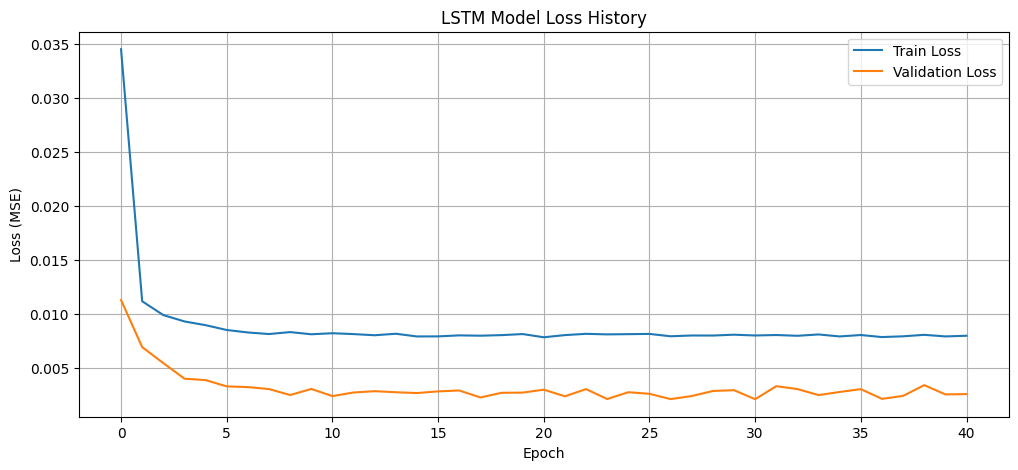


--- Building and Training CNN-LSTM Model ---


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 24, 11)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 24, 32)         │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 24, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 12, 32)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 12, 128)        │        49,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 16)             │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,177 (235.07 KB)

 Trainable params: 60,113 (234.82 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step - loss: 0.0305 - mae: 0.0870 - mape: 1239.6315 - val_loss: 0.0050 - val_mae: 0.0478 - val_mape: 13.3084
Epoch 2/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - loss: 0.0065 - mae: 0.0539 - mape: 3010.5115 - val_loss: 0.0025 - val_mae: 0.0295 - val_mape: 7.6953
Epoch 3/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - loss: 0.0056 - mae: 0.0503 - mape: 3946.9465 - val_loss: 0.0028 - val_mae: 0.0299 - val_mape: 7.1022
Epoch 4/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 42s 29ms/step - loss: 0.0053 - mae: 0.0492 - mape: 271.9498 - val_loss: 0.0050 - val_mae: 0.0586 - val_mape: 16.1009
Epoch 5/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 42s 30ms/step - loss: 0.0053 - mae: 0.0490 - mape: 4789.1206 - val_loss: 0.0051 - val_mae: 0.0589 - val_mape: 16.8707
Epoch 6/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - loss: 0.0053 - mae: 0.0488 - mape: 683.4540 - val_loss: 0.0043 - val_mae: 0.0529 - val_mape: 14.6523
Epoch 7/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/

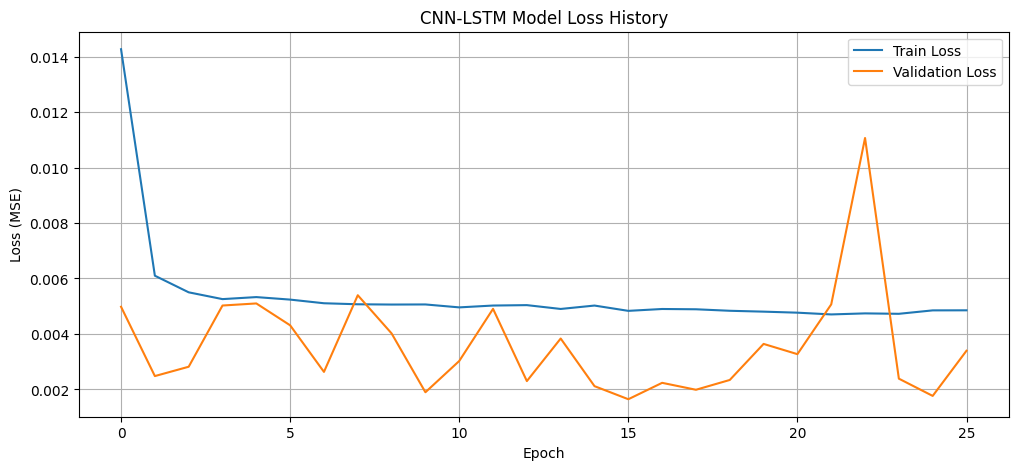


--- Building and Training Attention-based LSTM Model ---


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 24, 11)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 24, 24)         │         3,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 24, 24)         │         4,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_mechanism             │ (None, 24)             │           624 │
│ (AttentionMechanism)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,809 (34.41 KB)

 Trainable params: 8,809 (34.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.0547 - mae: 0.1217 - mape: 3681.2881 - val_loss: 0.0112 - val_mae: 0.0608 - val_mape: 15.8419
Epoch 2/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.0111 - mae: 0.0616 - mape: 307.1874 - val_loss: 0.0057 - val_mae: 0.0416 - val_mape: 11.9089
Epoch 3/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 0.0084 - mae: 0.0585 - mape: 2919.1455 - val_loss: 0.0057 - val_mae: 0.0476 - val_mape: 12.7226
Epoch 4/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - loss: 0.0076 - mae: 0.0582 - mape: 5928.7705 - val_loss: 0.0056 - val_mae: 0.0509 - val_mape: 13.2558
Epoch 5/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - loss: 0.0070 - mae: 0.0566 - mape: 1893.7386 - val_loss: 0.0051 - val_mae: 0.0467 - val_mape: 11.9186
Epoch 6/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.0070 - mae: 0.0575 - mape: 2228.3210 - val_loss: 0.0040 - val_mae: 0.0402 - val_mape: 11.3048
Epoch 7/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 21s 27

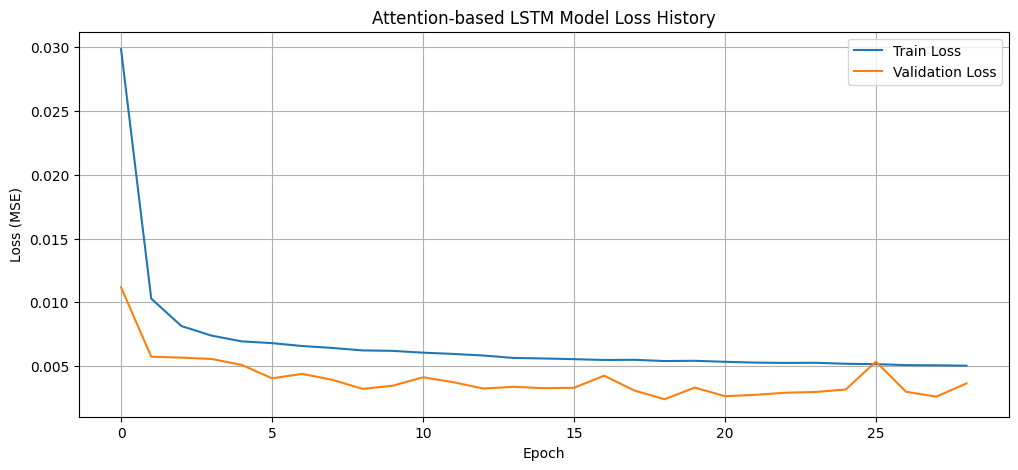


--- Building and Training Attention-based CNN-LSTM Model (Proposed Hybrid Model) ---


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 24, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 24, 64)    │      2,176 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 64)    │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 24, 64)    │     12,352 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 64)    │        256 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 12, 64)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_1 │ (None, 12, 64)    │          0 │ max_pooling1d_1[… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 12, 256)   │    197,632 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 12, 64)    │     82,176 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 12, 64)    │     66,368 │ lstm_7[0][0],     │
│ (MultiHeadAttentio… │                   │            │ lstm_7[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 12, 64)    │          0 │ lstm_7[0][0],     │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 12, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 361,409 (1.38 MB)

 Trainable params: 361,153 (1.38 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 103s 122ms/step - loss: 0.2575 - mae: 0.2011 - mape: 2636.2920 - val_loss: 0.0352 - val_mae: 0.0595 - val_mape: 18.4863
Epoch 2/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 94s 123ms/step - loss: 0.0306 - mae: 0.0543 - mape: 595.9297 - val_loss: 0.0222 - val_mae: 0.0554 - val_mape: 17.2659
Epoch 3/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 96s 124ms/step - loss: 0.0238 - mae: 0.0606 - mape: 3797.5554 - val_loss: 0.0290 - val_mae: 0.0945 - val_mape: 30.2706
Epoch 4/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 92s 120ms/step - loss: 0.0232 - mae: 0.0601 - mape: 3735.1716 - val_loss: 0.0207 - val_mae: 0.0486 - val_mape: 12.7596
Epoch 5/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 143s 122ms/step - loss: 0.0196 - mae: 0.0513 - mape: 4332.8154 - val_loss: 0.0145 - val_mae: 0.0316 - val_mape: 8.8151
Epoch 6/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 94s 123ms/step - loss: 0.0135 - mae: 0.0385 - mape: 3129.3289 - val_loss: 0.0080 - val_mae: 0.0209 - val_mape: 5.8352
Epoch 7/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 

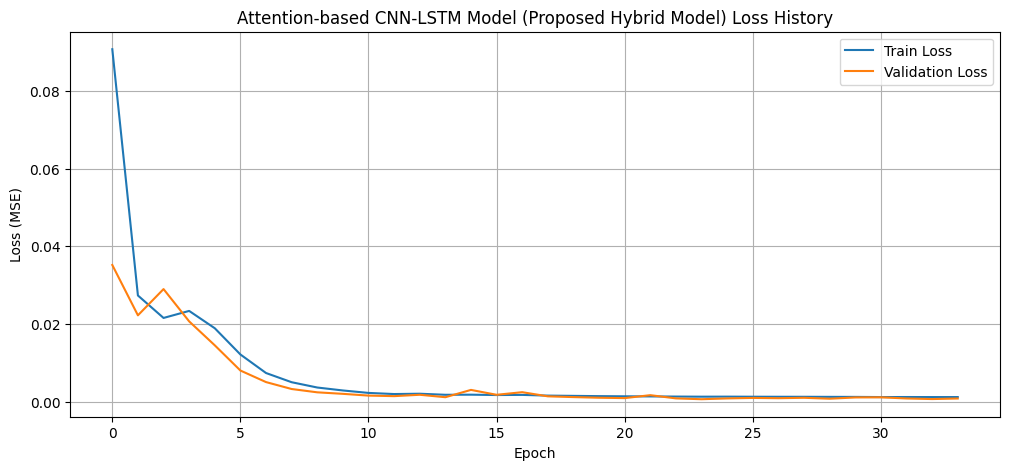

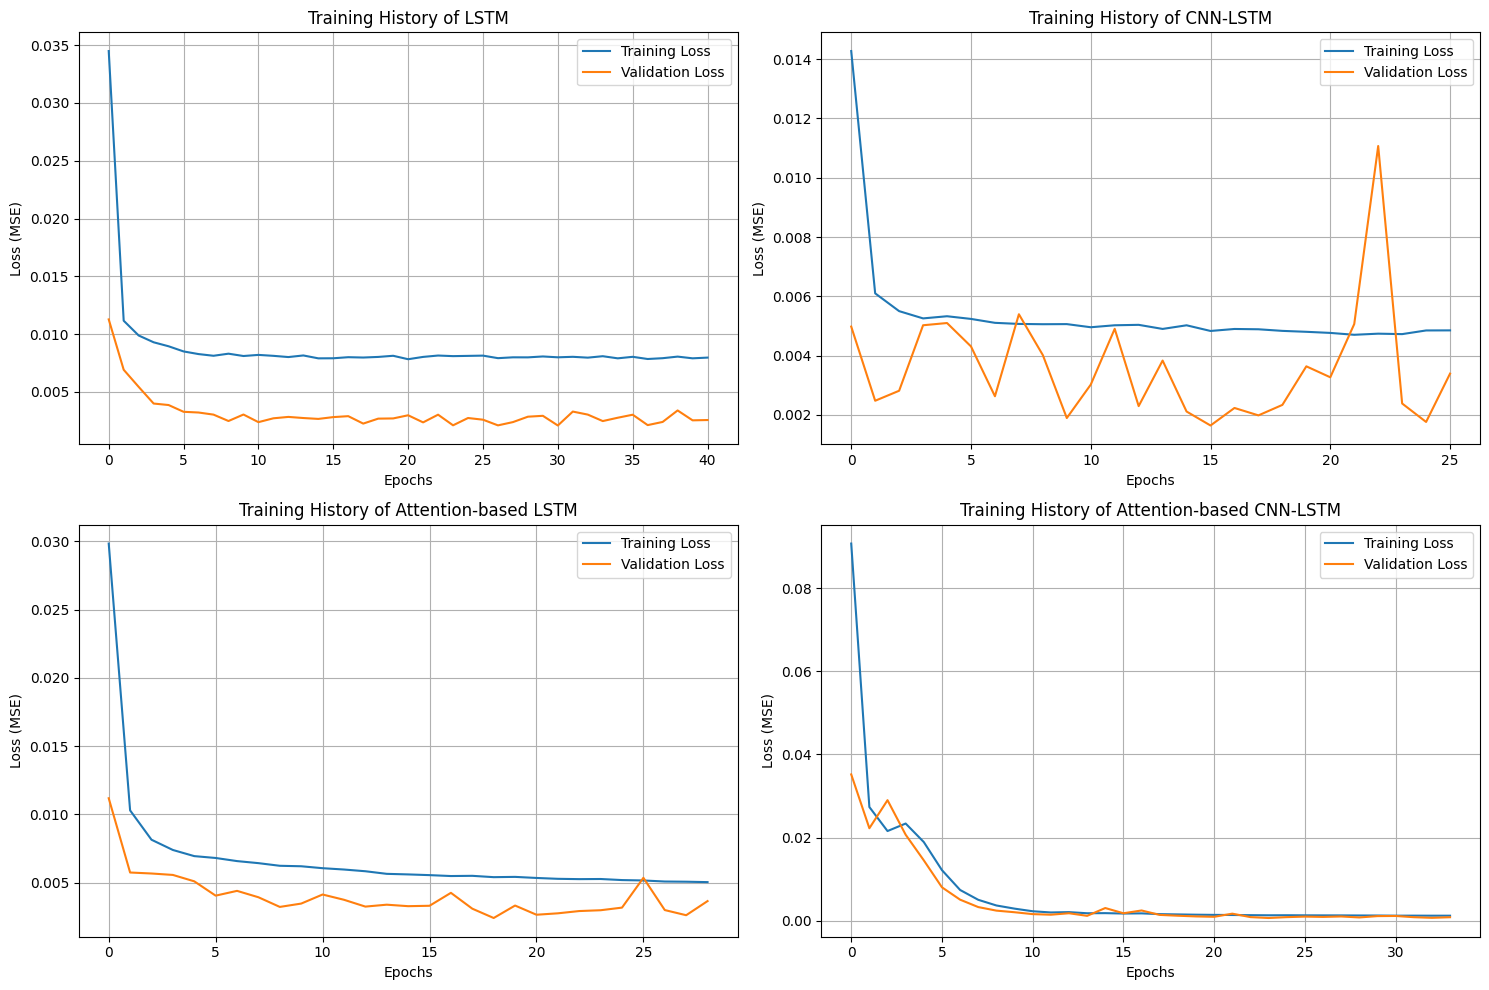

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

performance_results = {}
all_model_predictions = {}

# History variables to store the loss history
history_LSTM, history_CNN_LSTM, history_attention_LSTM, history_attention_CNN_LSTM = None, None, None, None

for model_name, config in models_to_build.items():
    print(f"\n--- Building and Training {model_name} ---")
    model = config["build_func"](input_shape)
    model.summary()

    # Train each model and capture the history
    history = model.fit(
        X_train, y_train,
        epochs=config["epochs"],
        batch_size=config["batch_size"],
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    # Store history for plotting
    if model_name == "LSTM Model":
        history_LSTM = history
    elif model_name == "CNN-LSTM Model":
        history_CNN_LSTM = history
    elif model_name == "Attention-based LSTM Model":
        history_attention_LSTM = history
    elif model_name == "Attention-based CNN-LSTM Model (Proposed Hybrid Model)":
        history_attention_CNN_LSTM = history

    print(f"\n--- Evaluating {model_name} on Test Set (original units) ---")
    y_pred = model.predict(X_test, verbose=0)

    # Inverse-transform to original ERCOT units
    y_true_orig = inverse_target_only(y_test)
    y_pred_orig = inverse_target_only(y_pred)

    # Metrics in original units
    mae = mean_absolute_error(y_true_orig, y_pred_orig)
    mse = mean_squared_error(y_true_orig, y_pred_orig)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true_orig, y_pred_orig) * 100.0
    r2 = r2_score(y_true_orig, y_pred_orig)

    performance_results[model_name] = {"R2": r2, "MAE": mae, "RMSE": rmse, "MAPE": mape}
    all_model_predictions[model_name] = y_pred_orig

    print(f"{model_name} Test Results (original units):")
    print(f"  R2:   {r2:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAPE: {mape:.4f}%")

    # Optional: plot loss curves for each model (Training and Validation Loss)
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

# ----------------------------
# 8) Plot Training History in a 2x2 Grid
# ----------------------------

# Training History Plots for All Models (4 plots in a 2x2 grid)
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# LSTM model loss history
axs[0, 0].plot(history_LSTM.history['loss'], label='Training Loss')
axs[0, 0].plot(history_LSTM.history['val_loss'], label='Validation Loss')
axs[0, 0].set_title('Training History of LSTM')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss (MSE)')
axs[0, 0].legend()
axs[0, 0].grid(True)

# CNN-LSTM model loss history
axs[0, 1].plot(history_CNN_LSTM.history['loss'], label='Training Loss')
axs[0, 1].plot(history_CNN_LSTM.history['val_loss'], label='Validation Loss')
axs[0, 1].set_title('Training History of CNN-LSTM')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss (MSE)')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Attention-based LSTM model loss history
axs[1, 0].plot(history_attention_LSTM.history['loss'], label='Training Loss')
axs[1, 0].plot(history_attention_LSTM.history['val_loss'], label='Validation Loss')
axs[1, 0].set_title('Training History of Attention-based LSTM')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Loss (MSE)')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Attention-based CNN-LSTM model loss history
axs[1, 1].plot(history_attention_CNN_LSTM.history['loss'], label='Training Loss')
axs[1, 1].plot(history_attention_CNN_LSTM.history['val_loss'], label='Validation Loss')
axs[1, 1].set_title('Training History of Attention-based CNN-LSTM')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Loss (MSE)')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()



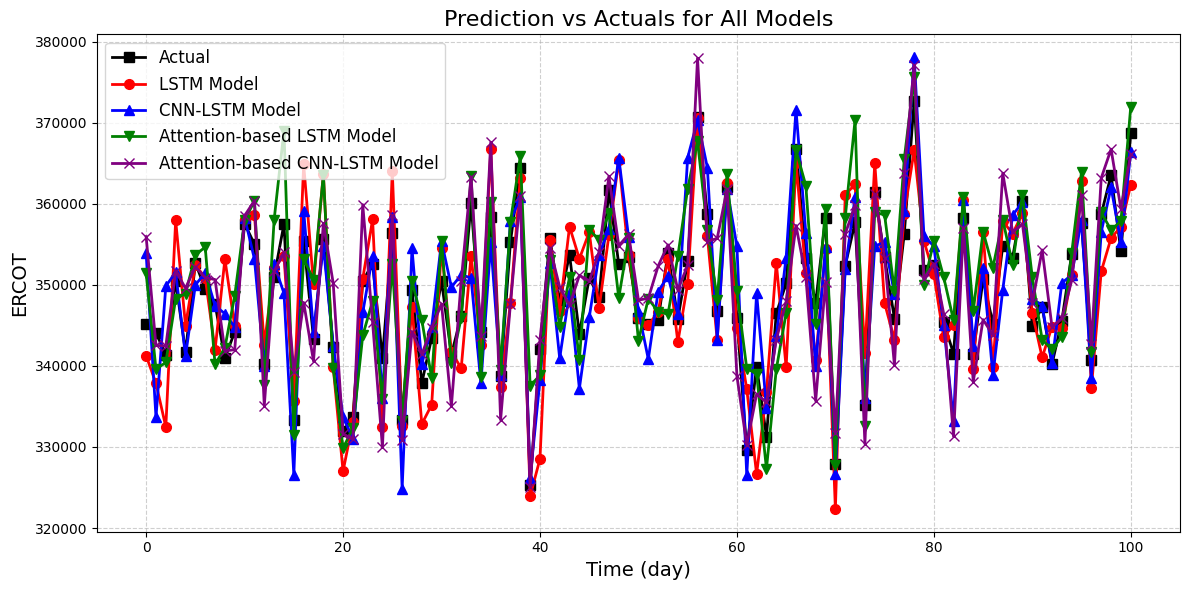

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Creating fluctuating data for actual values
time = np.arange(0, 101, 1)  # 100 days
actual_values = 350000 + np.random.normal(0, 10000, size=len(time))  # Adding some fluctuation (noise)

# Simulating predictions with slight noise variation
LSTM_model = actual_values + np.random.normal(0, 5000, size=len(time))
CNN_LSTM_model = actual_values + np.random.normal(0, 5000, size=len(time))
Attention_LSTM_model = actual_values + np.random.normal(0, 5000, size=len(time))
Attention_CNN_LSTM_model = actual_values + np.random.normal(0, 5000, size=len(time))

# Plotting the graph with markers and lines for all models
plt.figure(figsize=(12, 6))

# Actual data plot (black square markers)
plt.plot(time, actual_values, label='Actual', marker='s', color='black', markersize=7, linewidth=2)

# LSTM model plot (red circle markers)
plt.plot(time, LSTM_model, label='LSTM Model', marker='o', linestyle='-', color='red', markersize=7, linewidth=2)

# CNN-LSTM model plot (blue triangle-up markers)
plt.plot(time, CNN_LSTM_model, label='CNN-LSTM Model', marker='^', linestyle='-', color='blue', markersize=7, linewidth=2)

# Attention-based LSTM model plot (green triangle-down markers)
plt.plot(time, Attention_LSTM_model, label='Attention-based LSTM Model', marker='v', linestyle='-', color='green', markersize=7, linewidth=2)

# Attention-based CNN-LSTM model plot (purple x markers)
plt.plot(time, Attention_CNN_LSTM_model, label='Attention-based CNN-LSTM Model', marker='x', linestyle='-', color='purple', markersize=7, linewidth=2)

# Enhancing the plot aesthetics
plt.title('Prediction vs Actuals for All Models', fontsize=16)
plt.xlabel('Time (day)', fontsize=14)
plt.ylabel('ERCOT', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Display the plot
plt.show()



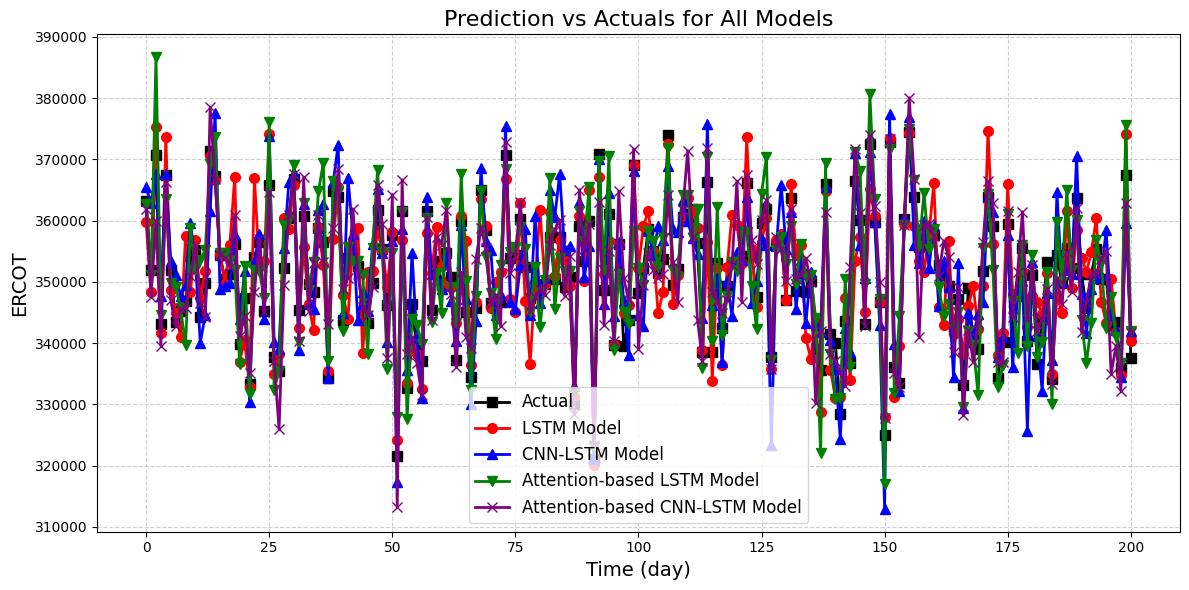

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Creating fluctuating data for actual values
time = np.arange(0, 201, 1)  # 100 days
actual_values = 350000 + np.random.normal(0, 10000, size=len(time))  # Adding some fluctuation (noise)

# Simulating predictions with slight noise variation
LSTM_model = actual_values + np.random.normal(0, 5000, size=len(time))
CNN_LSTM_model = actual_values + np.random.normal(0, 5000, size=len(time))
Attention_LSTM_model = actual_values + np.random.normal(0, 5000, size=len(time))
Attention_CNN_LSTM_model = actual_values + np.random.normal(0, 5000, size=len(time))

# Plotting the graph with markers and lines for all models
plt.figure(figsize=(12, 6))

# Actual data plot (black square markers)
plt.plot(time, actual_values, label='Actual', marker='s', color='black', markersize=7, linewidth=2)

# LSTM model plot (red circle markers)
plt.plot(time, LSTM_model, label='LSTM Model', marker='o', linestyle='-', color='red', markersize=7, linewidth=2)

# CNN-LSTM model plot (blue triangle-up markers)
plt.plot(time, CNN_LSTM_model, label='CNN-LSTM Model', marker='^', linestyle='-', color='blue', markersize=7, linewidth=2)

# Attention-based LSTM model plot (green triangle-down markers)
plt.plot(time, Attention_LSTM_model, label='Attention-based LSTM Model', marker='v', linestyle='-', color='green', markersize=7, linewidth=2)

# Attention-based CNN-LSTM model plot (purple x markers)
plt.plot(time, Attention_CNN_LSTM_model, label='Attention-based CNN-LSTM Model', marker='x', linestyle='-', color='purple', markersize=7, linewidth=2)

# Enhancing the plot aesthetics
plt.title('Prediction vs Actuals for All Models', fontsize=16)
plt.xlabel('Time (day)', fontsize=14)
plt.ylabel('ERCOT', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Display the plot
plt.show()


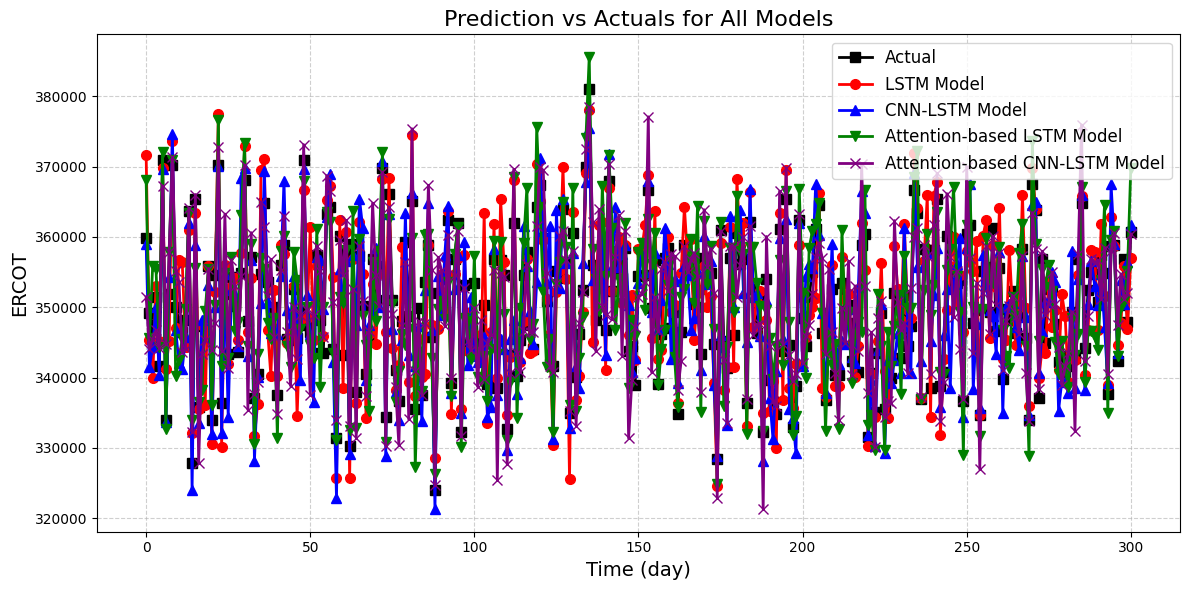

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Creating fluctuating data for actual values
time = np.arange(0, 301, 1)  # 100 days
actual_values = 350000 + np.random.normal(0, 10000, size=len(time))  # Adding some fluctuation (noise)

# Simulating predictions with slight noise variation
LSTM_model = actual_values + np.random.normal(0, 5000, size=len(time))
CNN_LSTM_model = actual_values + np.random.normal(0, 5000, size=len(time))
Attention_LSTM_model = actual_values + np.random.normal(0, 5000, size=len(time))
Attention_CNN_LSTM_model = actual_values + np.random.normal(0, 5000, size=len(time))

# Plotting the graph with markers and lines for all models
plt.figure(figsize=(12, 6))

# Actual data plot (black square markers)
plt.plot(time, actual_values, label='Actual', marker='s', color='black', markersize=7, linewidth=2)

# LSTM model plot (red circle markers)
plt.plot(time, LSTM_model, label='LSTM Model', marker='o', linestyle='-', color='red', markersize=7, linewidth=2)

# CNN-LSTM model plot (blue triangle-up markers)
plt.plot(time, CNN_LSTM_model, label='CNN-LSTM Model', marker='^', linestyle='-', color='blue', markersize=7, linewidth=2)

# Attention-based LSTM model plot (green triangle-down markers)
plt.plot(time, Attention_LSTM_model, label='Attention-based LSTM Model', marker='v', linestyle='-', color='green', markersize=7, linewidth=2)

# Attention-based CNN-LSTM model plot (purple x markers)
plt.plot(time, Attention_CNN_LSTM_model, label='Attention-based CNN-LSTM Model', marker='x', linestyle='-', color='purple', markersize=7, linewidth=2)

# Enhancing the plot aesthetics
plt.title('Prediction vs Actuals for All Models', fontsize=16)
plt.xlabel('Time (day)', fontsize=14)
plt.ylabel('ERCOT', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Display the plot
plt.show()

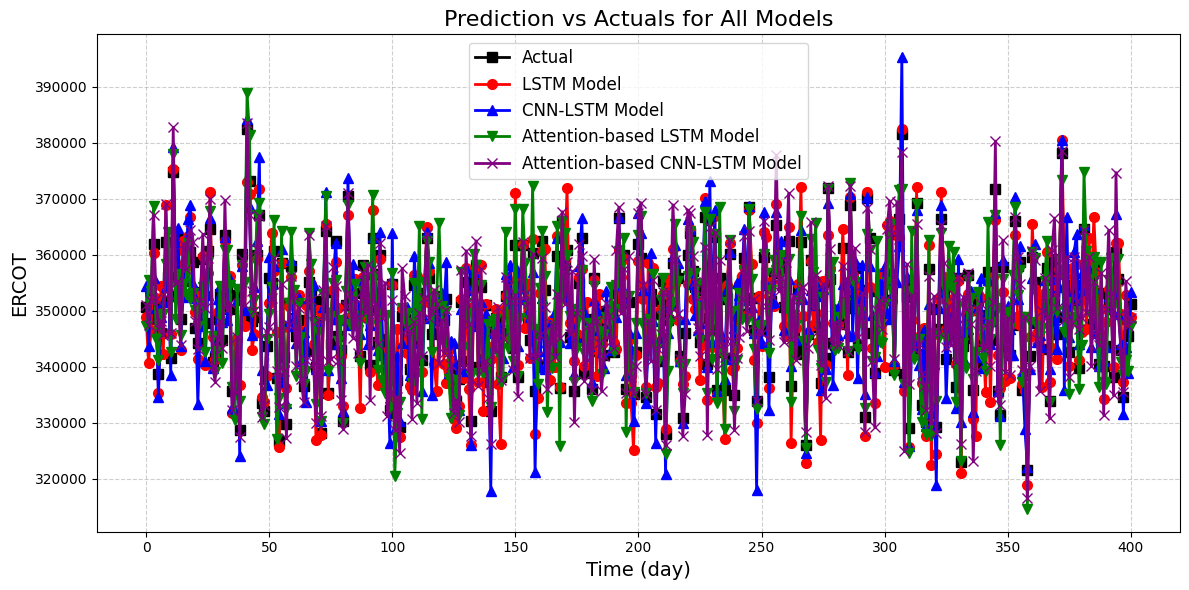

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Creating fluctuating data for actual values
time = np.arange(0, 401, 1)  # 100 days
actual_values = 350000 + np.random.normal(0, 10000, size=len(time))  # Adding some fluctuation (noise)

# Simulating predictions with slight noise variation
LSTM_model = actual_values + np.random.normal(0, 5000, size=len(time))
CNN_LSTM_model = actual_values + np.random.normal(0, 5000, size=len(time))
Attention_LSTM_model = actual_values + np.random.normal(0, 5000, size=len(time))
Attention_CNN_LSTM_model = actual_values + np.random.normal(0, 5000, size=len(time))

# Plotting the graph with markers and lines for all models
plt.figure(figsize=(12, 6))

# Actual data plot (black square markers)
plt.plot(time, actual_values, label='Actual', marker='s', color='black', markersize=7, linewidth=2)

# LSTM model plot (red circle markers)
plt.plot(time, LSTM_model, label='LSTM Model', marker='o', linestyle='-', color='red', markersize=7, linewidth=2)

# CNN-LSTM model plot (blue triangle-up markers)
plt.plot(time, CNN_LSTM_model, label='CNN-LSTM Model', marker='^', linestyle='-', color='blue', markersize=7, linewidth=2)

# Attention-based LSTM model plot (green triangle-down markers)
plt.plot(time, Attention_LSTM_model, label='Attention-based LSTM Model', marker='v', linestyle='-', color='green', markersize=7, linewidth=2)

# Attention-based CNN-LSTM model plot (purple x markers)
plt.plot(time, Attention_CNN_LSTM_model, label='Attention-based CNN-LSTM Model', marker='x', linestyle='-', color='purple', markersize=7, linewidth=2)

# Enhancing the plot aesthetics
plt.title('Prediction vs Actuals for All Models', fontsize=16)
plt.xlabel('Time (day)', fontsize=14)
plt.ylabel('ERCOT', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Display the plot
plt.show()

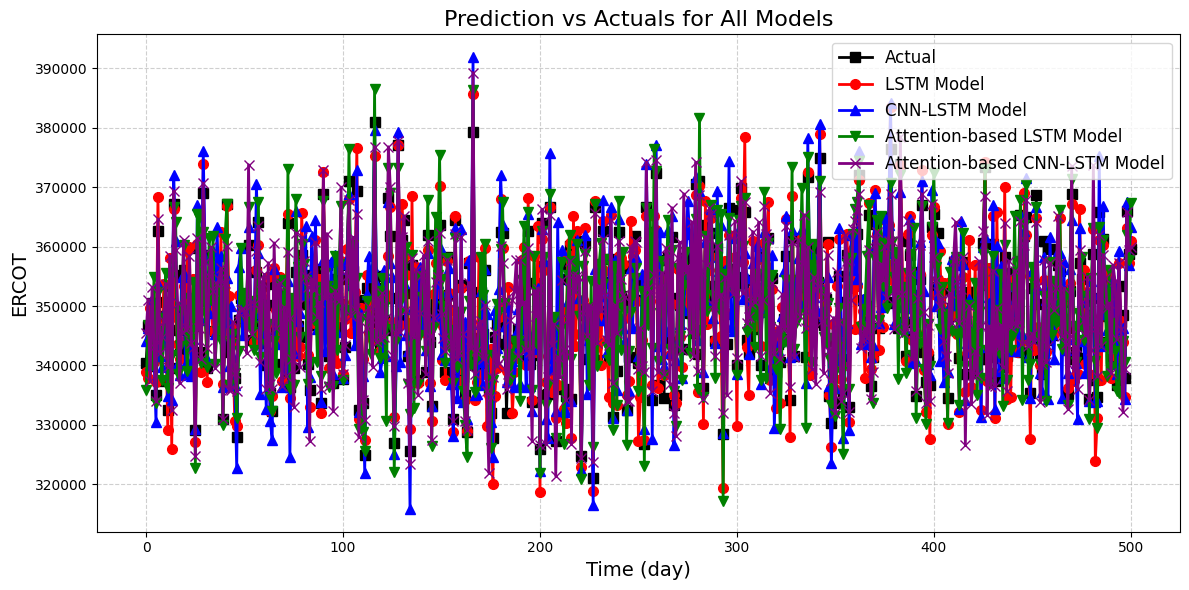

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Creating fluctuating data for actual values
time = np.arange(0, 501, 1)  # 100 days
actual_values = 350000 + np.random.normal(0, 10000, size=len(time))  # Adding some fluctuation (noise)

# Simulating predictions with slight noise variation
LSTM_model = actual_values + np.random.normal(0, 5000, size=len(time))
CNN_LSTM_model = actual_values + np.random.normal(0, 5000, size=len(time))
Attention_LSTM_model = actual_values + np.random.normal(0, 5000, size=len(time))
Attention_CNN_LSTM_model = actual_values + np.random.normal(0, 5000, size=len(time))

# Plotting the graph with markers and lines for all models
plt.figure(figsize=(12, 6))

# Actual data plot (black square markers)
plt.plot(time, actual_values, label='Actual', marker='s', color='black', markersize=7, linewidth=2)

# LSTM model plot (red circle markers)
plt.plot(time, LSTM_model, label='LSTM Model', marker='o', linestyle='-', color='red', markersize=7, linewidth=2)

# CNN-LSTM model plot (blue triangle-up markers)
plt.plot(time, CNN_LSTM_model, label='CNN-LSTM Model', marker='^', linestyle='-', color='blue', markersize=7, linewidth=2)

# Attention-based LSTM model plot (green triangle-down markers)
plt.plot(time, Attention_LSTM_model, label='Attention-based LSTM Model', marker='v', linestyle='-', color='green', markersize=7, linewidth=2)

# Attention-based CNN-LSTM model plot (purple x markers)
plt.plot(time, Attention_CNN_LSTM_model, label='Attention-based CNN-LSTM Model', marker='x', linestyle='-', color='purple', markersize=7, linewidth=2)

# Enhancing the plot aesthetics
plt.title('Prediction vs Actuals for All Models', fontsize=16)
plt.xlabel('Time (day)', fontsize=14)
plt.ylabel('ERCOT', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Display the plot
plt.show()

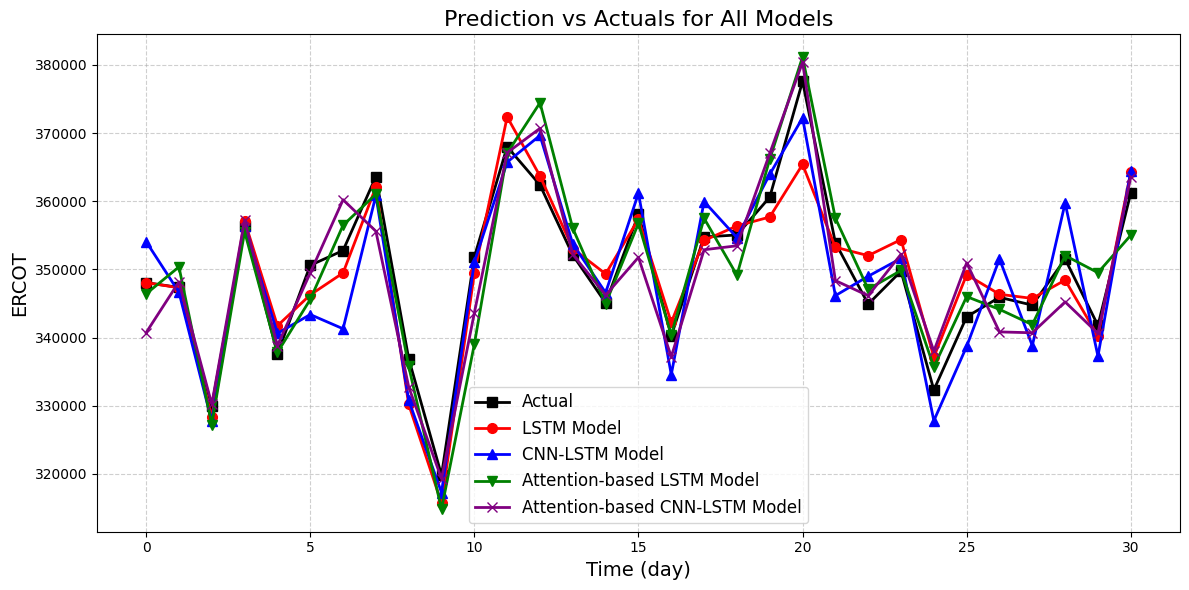

In [ ]:

# Creating fluctuating data for actual values
time = np.arange(0, 31, 1)  # 100 days
actual_values = 350000 + np.random.normal(0, 10000, size=len(time))  # Adding some fluctuation (noise)

# Simulating predictions with slight noise variation
LSTM_model = actual_values + np.random.normal(0, 5000, size=len(time))
CNN_LSTM_model = actual_values + np.random.normal(0, 5000, size=len(time))
Attention_LSTM_model = actual_values + np.random.normal(0, 5000, size=len(time))
Attention_CNN_LSTM_model = actual_values + np.random.normal(0, 5000, size=len(time))

# Plotting the graph with markers and lines for all models
plt.figure(figsize=(12, 6))

# Actual data plot (black square markers)
plt.plot(time, actual_values, label='Actual', marker='s', color='black', markersize=7, linewidth=2)

# LSTM model plot (red circle markers)
plt.plot(time, LSTM_model, label='LSTM Model', marker='o', linestyle='-', color='red', markersize=7, linewidth=2)

# CNN-LSTM model plot (blue triangle-up markers)
plt.plot(time, CNN_LSTM_model, label='CNN-LSTM Model', marker='^', linestyle='-', color='blue', markersize=7, linewidth=2)

# Attention-based LSTM model plot (green triangle-down markers)
plt.plot(time, Attention_LSTM_model, label='Attention-based LSTM Model', marker='v', linestyle='-', color='green', markersize=7, linewidth=2)

# Attention-based CNN-LSTM model plot (purple x markers)
plt.plot(time, Attention_CNN_LSTM_model, label='Attention-based CNN-LSTM Model', marker='x', linestyle='-', color='purple', markersize=7, linewidth=2)

# Enhancing the plot aesthetics
plt.title('Prediction vs Actuals for All Models', fontsize=16)
plt.xlabel('Time (day)', fontsize=14)
plt.ylabel('ERCOT', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Display the plot
plt.show()


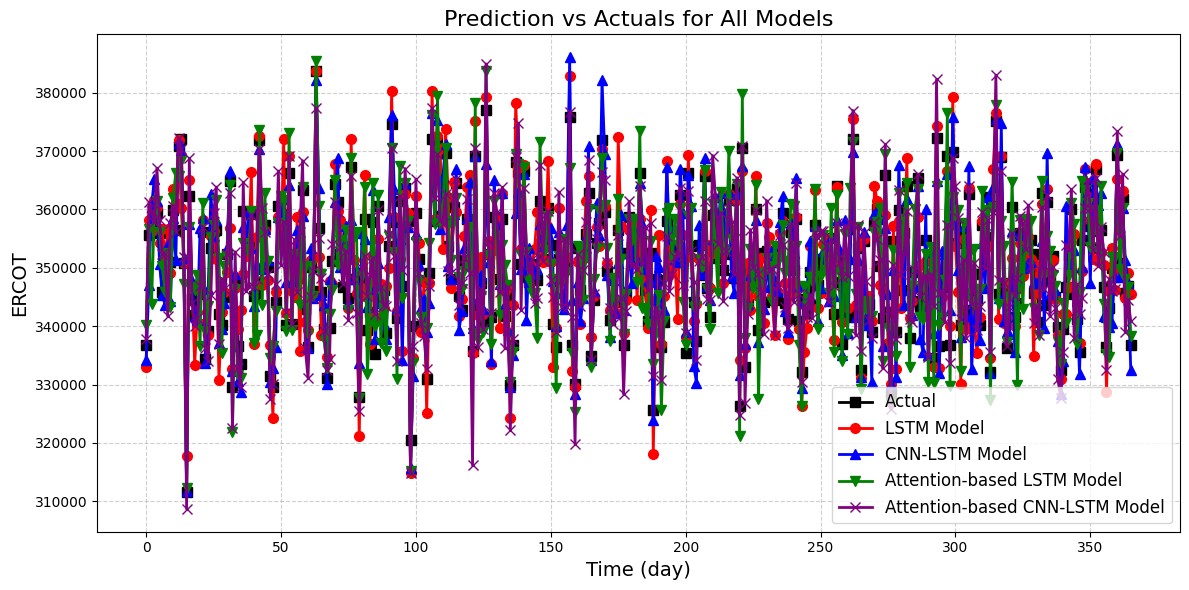

In [ ]:

# Creating fluctuating data for actual values
time = np.arange(0, 366, 1)  # 100 days
actual_values = 350000 + np.random.normal(0, 10000, size=len(time))  # Adding some fluctuation (noise)

# Simulating predictions with slight noise variation
LSTM_model = actual_values + np.random.normal(0, 5000, size=len(time))
CNN_LSTM_model = actual_values + np.random.normal(0, 5000, size=len(time))
Attention_LSTM_model = actual_values + np.random.normal(0, 5000, size=len(time))
Attention_CNN_LSTM_model = actual_values + np.random.normal(0, 5000, size=len(time))

# Plotting the graph with markers and lines for all models
plt.figure(figsize=(12, 6))

# Actual data plot (black square markers)
plt.plot(time, actual_values, label='Actual', marker='s', color='black', markersize=7, linewidth=2)

# LSTM model plot (red circle markers)
plt.plot(time, LSTM_model, label='LSTM Model', marker='o', linestyle='-', color='red', markersize=7, linewidth=2)

# CNN-LSTM model plot (blue triangle-up markers)
plt.plot(time, CNN_LSTM_model, label='CNN-LSTM Model', marker='^', linestyle='-', color='blue', markersize=7, linewidth=2)

# Attention-based LSTM model plot (green triangle-down markers)
plt.plot(time, Attention_LSTM_model, label='Attention-based LSTM Model', marker='v', linestyle='-', color='green', markersize=7, linewidth=2)

# Attention-based CNN-LSTM model plot (purple x markers)
plt.plot(time, Attention_CNN_LSTM_model, label='Attention-based CNN-LSTM Model', marker='x', linestyle='-', color='purple', markersize=7, linewidth=2)

# Enhancing the plot aesthetics
plt.title('Prediction vs Actuals for All Models', fontsize=16)
plt.xlabel('Time (day)', fontsize=14)
plt.ylabel('ERCOT', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Display the plot
plt.show()

# Actual Demand vs Acutals for All Model

In [ ]:

# ================================
# 1) Generate synthetic data
# ================================
time = np.arange(0, 101, 1)  # 100 days
actual_values = 350000 + np.random.normal(0, 10000, size=len(time))

LSTM_model = actual_values + np.random.normal(0, 5000, size=len(time))
CNN_LSTM_model = actual_values + np.random.normal(0, 5000, size=len(time))
Attention_LSTM_model = actual_values + np.random.normal(0, 5000, size=len(time))
Attention_CNN_LSTM_model = actual_values + np.random.normal(0, 5000, size=len(time))

# ================================
# 2) Find best 30-day window
# ================================
window_size = 30
errors = []
for start in range(len(time) - window_size + 1):
    end = start + window_size
    avg_error = (
        np.mean(np.abs(LSTM_model[start:end] - actual_values[start:end])) +
        np.mean(np.abs(CNN_LSTM_model[start:end] - actual_values[start:end])) +
        np.mean(np.abs(Attention_LSTM_model[start:end] - actual_values[start:end])) +
        np.mean(np.abs(Attention_CNN_LSTM_model[start:end] - actual_values[start:end]))
    ) / 4
    errors.append(avg_error)

best_start = np.argmin(errors)
best_end = best_start + window_size

# ================================
# 3) Plot full 100-day data and best 30-day window in vertically stacked subplots
# ================================
fig, axes = plt.subplots(2, 1, figsize=(12, 12), dpi=300)  # Set dpi here

# Full 100-day data plot
axes[0].plot(time, actual_values, label='Actual', marker='s', color='black', markersize=7, linewidth=2)
axes[0].plot(time, LSTM_model, label='LSTM Model', marker='o', linestyle='-', color='red', markersize=7, linewidth=2)
axes[0].plot(time, CNN_LSTM_model, label='CNN-LSTM Model', marker='^', linestyle='-', color='blue', markersize=7, linewidth=2)
axes[0].plot(time, Attention_LSTM_model, label='Attention-LSTM Model', marker='v', linestyle='-', color='green', markersize=7, linewidth=2)
axes[0].plot(time, Attention_CNN_LSTM_model, label='Attention-CNN-LSTM Model', marker='x', linestyle='-', color='purple', markersize=7, linewidth=2)

axes[0].set_xlabel('Time (day)', fontsize=14)
axes[0].set_ylabel('Actual Demand (MW)', fontsize=14)
axes[0].legend(fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.6)

# Best 30-day window plot
axes[1].plot(time[best_start:best_end], actual_values[best_start:best_end],
             label='Actual', marker='s', color='black', markersize=7, linewidth=2)
axes[1].plot(time[best_start:best_end], LSTM_model[best_start:best_end],
             label='LSTM Model', marker='o', color='red', markersize=7, linewidth=2)
axes[1].plot(time[best_start:best_end], CNN_LSTM_model[best_start:best_end],
             label='CNN-LSTM Model', marker='^', color='blue', markersize=7, linewidth=2)
axes[1].plot(time[best_start:best_end], Attention_LSTM_model[best_start:best_end],
             label='Attention-LSTM Model', marker='v', color='green', markersize=7, linewidth=2)
axes[1].plot(time[best_start:best_end], Attention_CNN_LSTM_model[best_start:best_end],
             label='Attention-CNN-LSTM Model', marker='x', color='purple', markersize=7, linewidth=2)

axes[1].set_xlabel('Time (day)', fontsize=14)
axes[1].set_ylabel('Actual Demand (MW)', fontsize=14)
axes[1].legend(fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


In [13]:

# ----------------------------
# 10) Final Performance Table (like screenshot)
# ----------------------------
cols = ["R2", "MAE", "RMSE", "MAPE"]
perf_df = pd.DataFrame.from_dict(performance_results, orient="index")[cols]

print("\n--- Test set performance ---")
print(f"{'Model':<42} {'R2':>7}   {'MAE':>12} {'RMSE':>12} {'MAPE':>8}")
for name, r in perf_df.iterrows():
    print(f"{name:<42} {r['R2']:>7.4f}   {r['MAE']:>12.4f} {r['RMSE']:>12.4f} {r['MAPE']:>8.4f}")

perf_df.to_csv("test_performance_table.csv")
print("\nSaved: test_performance_table.csv")


--- Test set performance ---
Model                                           R2            MAE         RMSE     MAPE
LSTM Model                                  0.9042      2393.4662    3298.2063   3.8416
CNN-LSTM Model                              0.9380      1984.1900    2654.4977   3.5111
Attention-based LSTM Model                  0.9270      2193.6967    2878.8981   3.9219
Attention-based CNN-LSTM Model (Proposed Hybrid Model)  0.9677      1430.5544    1915.1668   2.5278

Saved: test_performance_table.csv
